# INFO 3950 Problem Set 3

name: Kate Li 

netid: kl739

In [3]:
import matplotlib.pyplot as plt, numpy as np
from sklearn.linear_model import LogisticRegression

### 1) Challenger data, trial-and-error fit

**A. Plot the data as below, and by eye try to adjust the $w$ and $b$ parameters so that the logistic fit looks roughly as pictured. (recall from lec11 what the effects of changing $w$ and $b$ are)**

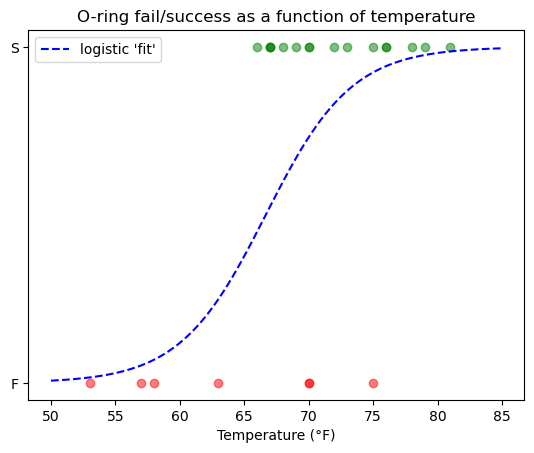

In [6]:
#first plot the data
S = np.array([66, 69, 68, 67, 72, 73, 70, 78, 67, 67, 75, 70, 81, 76, 79, 76]) # where successes
F = np.array([70, 57, 63, 70, 53, 75, 58]) # where failures

# define the logit function
def logit(T, w, b):
    return 1 / (1 + np.exp(-(w * T + b)))

# initialize w and b (adjustable)
w = 0.3
b = -20

T = np.linspace(50, 85, 200) # to draw the logistic fit
l = logit(T, w, b) # defines the logistic function

fig = plt.figure()
plt.scatter(S, np.ones_like(S), color = 'green', alpha = 0.5) # plots the success data
plt.scatter(F, np.zeros_like(F), color = 'red', alpha = 0.5) # plots the failure data

# plot of data points and logistic fit
plt.plot(T, l, color = 'blue', linestyle = '--', label = "logistic 'fit'")
plt.xlabel('Temperature (°F)')
plt.yticks([0, 1], ['F', 'S'])
plt.title('O-ring fail/success as a function of temperature')
plt.legend()
plt.show()

**B. From your logistic fit to the data, determine the probability of failure at the actual launch temperature T=31∘
 F.**

In [8]:
prob_fail = 1 - logit(31, w, b)
print(f"Probability of failure: {prob_fail}")

Probability of failure: 0.9999774555703496


**C. In this model, the joint probability of success at the three largest temperatures is given by the product $p(81)*p(79)*p(78)$. What is the result for your choice of $w$, $b$?**

In [10]:
prob_81 = logit(81, w, b)
prob_79 = logit(79, w, b)
prob_78 = logit(78, w, b)

joint_prob = prob_81 * prob_79 * prob_78
print(f"Joint prob of success at 3 largest temps: {joint_prob}")

Joint prob of success at 3 largest temps: 0.9317146816123619


**D. The probability of failure is given by $1-p(T)$, so the joint probability of failure at the three smallest temperatures is given by $(1-p(53))*(1-p(57))*(1-p(58))$. What is the result for your choice of $w$, $b$?**

In [12]:
prob_53 = 1 - logit(53, w, b)
prob_57 = 1 - logit(57, w, b)
prob_58 = 1 - logit(58, w, b)

joint_prob = prob_53 * prob_57 * prob_58
print(f"Joint prob of failure at 3 smallest temps: {joint_prob}")

Joint prob of failure at 3 smallest temps: 0.8679299108605826


**E. The overall likelihood of the data $p({\rm data}\,|\, w,b)$ is given by the product of the predicted probabilities for all of the data points, so the product of $(1-p(T))$ for the failure values times the product of $p(T)$ for the success values.<br>
(Note that values that occur more than once should be included with multiplicity -- those are the ones that appear darker red or darker green in the below, since they were plotted with alpha=.33). What is that product for your values of $w$ and $b$?**

In [14]:
prob_success = 1
for s in S:
    prob = logit(s, w, b)
    prob_success *= prob

prob_failure = 1
for f in F:
    prob = 1 - logit(f, w, b)
    prob_failure *= prob

product_prob = prob_success * prob_failure
print(f"Product of predicted probs: {product_prob}")

Product of predicted probs: 2.7552485500751902e-05


**F. In logistic regression, the optimal values of $w$ and $b$ are chosen algorithmically to maximize the above-defined "probability of the data" $p({\rm data}\,|\, w,b)$. Since the log() function is monotonic, that is equivalent to maximizing $\log(p({\rm data}\,|\, w,b))$ (where the log in this case is `np.log()`, i.e., in base e). In machine learning, it is conventional to define an objective function that is minimized rather than maximized, and hence termed the "cost function".<br>
For logistic regression, that cost function is taken as $C(w,b) = -{1\over n}\log(p({\rm data}\,|\, w,b))$ (since minimizing $C$ corresponds to maximizing $-C$), and the values of $w$, $b$ at its minimum provide the "best" fit to the data. Here $n=23$ is the number of data points, dividing by which gives the "mean loss" per data point.<br>
Evaluate this cost function $C(w,b)$ for your values of $w,b$.**

In [16]:
def cost_function(S, F, n, w, b):
    prob_success = 1
    for s in S:
        prob = logit(s, w, b)
        prob_success *= prob
    
    prob_failure = 1
    for f in F:
        prob = 1 - logit(f, w, b)
        prob_failure *= prob

    product_prob = prob_success * prob_failure
        
    return (-1 / n)*(np.log(product_prob))

In [17]:
n = 23
func = cost_function(S, F, n, w, b)
print(f"cost function evaluation for my w, b: {func}")

cost function evaluation for my w, b: 0.4564964264618085


### 2) Challenger data, grid-search fit
Rather than trying trying to guess the values of $w,b$ by eye, a more principled method could be a grid search. That means to evaluate the cost function $C(w,b)$ above for values $w,b$ on some set of grid points in the parameter space, and choose the values that minimize this function.

For an outer loop over $w$, we can chose the 100 points `np.linspace(.01, 1., 100)` from .01 to 100 in increments of .01. To slightly optimize the search over $b$, it's useful to recall that the logit function has its intermediate value of 1/2 when $wT+b=0$, i.e., when $T=-b/w$. From inspection, we see that the transition has to occur somewhere between temperatures of 50 and 85 (actually somewhere in the 60s, but we'll stay with the full range of the data). So it makes sense to let $b$ take the values `-w*np.arange(50, 85, .5)`, ranging from $-50*w$ to $-85*w$ in increments of $.5*w$, so that the grid probes the same 70 transition temperatures from 50 to 84.5 for each value of $w$. (Otherwise the grid might be too sparse in the region of interest.)

In [19]:
w_values = np.linspace(0.01, 1.0, 100)
w_grid = []
b_grid = []

for w in w_values:
    b_values = -w * np.arange(50, 85, 0.5)    

    for b in b_values:
        w_grid.append(w)
        b_grid.append(b)
        
w_arr = np.array(w_grid)
b_arr = np.array(b_grid)

**A. For the $70\times 100= 7000$ values of $w,b$ in the above grid, find the values of $w,b$ that minimize $C(w,b)$. (One way to do this is to calculate the full 2-d array of values, and use `.argmin()`, but there are many ways). How does the minimum value of $C$ compare to your guess from problem 1 above?**

In [21]:
C_values = np.array([cost_function(S, F, n, w, b) for w, b in zip(w_arr, b_arr)])
index = np.argmin(C_values)

opt_w = w_arr[index]
opt_b = b_arr[index]
C = C_values[index]

print(f"w: {opt_w:.2f}, b: {opt_b:.2f}, minimum C: {C}")

w: 0.24, b: -15.60, minimum C: 0.44178774197485127


The minimum value of C, where w and b were calculated through grid search, is slightly lower than my guess from problem 1, where w and b were determined by eye.

**B. For these optimum values, plot the value of the loss $-\log p(T|w,b)$ or $-\log (1-p(T|w,b))$ (for success and failure temperatures, resp) as a function of temperature for each of the 23 data points. Include a horizontal dashed line showing the value of the mean loss.**

In [24]:
losses = []
temp = []

for T in S:
    loss = -np.log(logit(T, opt_w, opt_b))
    losses.append(loss)
    temp.append(T)

for T in F:
    loss = -np.log(1 - logit(T, opt_w, opt_b))
    losses.append(loss)
    temp.append(T)

losses = np.array(losses)
temp = np.array(temp)

mean_loss = losses.mean()

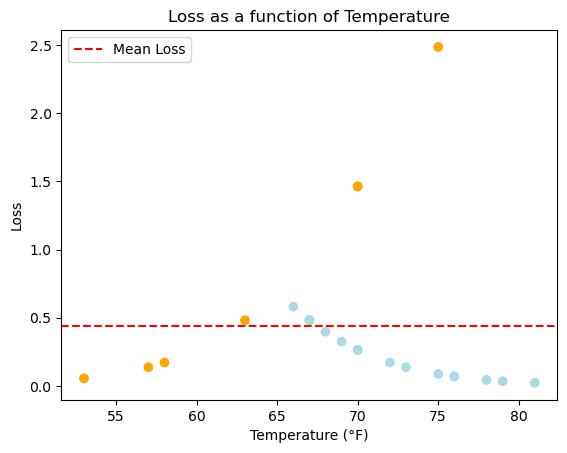

In [25]:
fig = plt.figure()

color = ['lightblue' if i < len(S) else 'orange' for i in range(len(losses))]
plt.scatter(x = temp, y = losses, c = color, marker = 'o')
plt.axhline(y = mean_loss, color = 'r', linestyle = '--', label = 'Mean Loss')

plt.xlabel('Temperature (°F)')
plt.ylabel('Loss')
plt.title('Loss as a function of Temperature')
plt.legend()
plt.show()

### 3) Challenger data, scikit-learn fit

**A.** In problem 1 above, you found a logistic fit to the Challenger data by visually guessing, and problem 2 used a grid search to refine the fit. In this problem, use the [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to fit the two parameters
(see also [plot_logistic](http://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html)).

There are two minor subtleties:<br>
     $\quad\bullet$ For the X_data the scikit learn functions expect multi-dimensional data, so one-dimensional temperature data `[70, 57, 63, 70, 53, ...]` instead has to be in the form `[[70], [57], [63], [70], [53], ...]`, which can be created from the lists above via `X = np.array(X_data)[:, None]`, i.e., adding an empty second dimension to each data point (or via `X = [[x] for x in X_data]`, or via `X = np.expand_dims(X_data, axis=1)`). The attributes `.coef_` and `.intercept_` of the fitted logistic classifier give respectively `w` and `b`, since they appear as `(coef *t + intercept) = w*T+b` in the argument of the exponential.<br>
     $\quad\bullet$ By default scikit-learn's `LogisticRegression()` comes with a "regularization" parameter `C`  turned on (and not to be confused with the above cost function $C(w,b)$), to prevent overfitting by constraining the parameters to be small. That isn't a concern here with only two parameters, so the regularization can be disabled by initializing with a large value of `C`, e.g., `LogisticRegression(C=1e6)`. You can also increase the accuracy of the result by lowering the tolerance from the default to, say, `tol=1e-6` (though that may require increasing `max_iter`).

**Fit the data, find the optimal parameter values of $w,b$.
Calculate the mean loss $C(w,b)$ and compare to the values found in problems 1,2.**

In [28]:
X = [[T] for T in temp]
y = np.array([1]*len(S) + [0]*len(F))

model = LogisticRegression(C=1e6).fit(X, y)
opt_w = model.coef_[0, 0]
opt_b = model.intercept_[0]

mean_loss_new = cost_function(S, F, n, opt_w, opt_b)

print(f"w: {opt_w}, b: {opt_b}, mean loss: {mean_loss_new}")

w: 0.23216273825425812, b: -15.042901243151054, mean loss: 0.4416346236492788


**B. Use the `.score()` method to determine how many of the points the trained classifier gets wrong on the training set. What are the X and y values of those points (temperatures and training values)?**

In [30]:
score = model.score(X, y)
num_correct = score * len(y)
num_incorrect = len(y) - num_correct

pred = model.predict(X)

indices = np.where(pred != y)[0]

incorrect_X = []
incorrect_y = []

for i in indices:
    incorrect_X.append(X[i])
    incorrect_y.append(y[i])

print(incorrect_X)
print(incorrect_y)

[[70], [70], [75]]
[0, 0, 0]


**C. Add to the plot from problem 2B the values of the loss for the 23 data point using these new values of $w,b$, and include as well a horizontal dashed line for this new value of the mean loss.**

**(Use different colors for the loss data from the three problems, with color associated to each specified in a figure legend.)**

In [32]:
new_losses = []
temp = []

for T in S:
    loss = -np.log(logit(T, opt_w, opt_b))
    new_losses.append(loss)
    temp.append(T)

for T in F:
    loss = -np.log(1 - logit(T, opt_w, opt_b))
    new_losses.append(loss)
    temp.append(T)

new_losses = np.array(new_losses)
temp = np.array(temp)

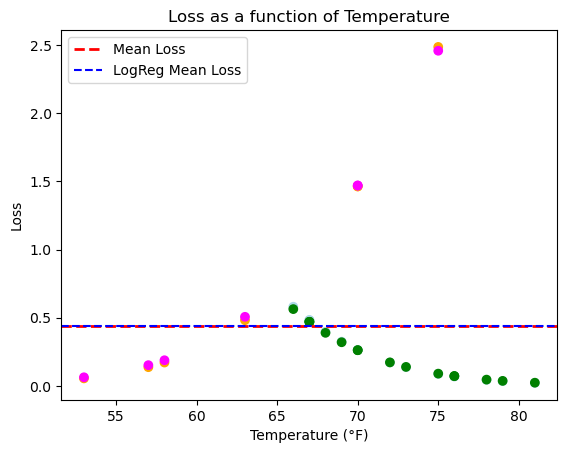

In [33]:
fig = plt.figure()

color = ['lightblue' if i < len(S) else 'orange' for i in range(len(losses))]
plt.scatter(x = temp, y = losses, c = color, marker = 'o')
plt.axhline(y = mean_loss, color = 'r', linestyle = '--', label = 'Mean Loss', linewidth = 2.0)

new_color = ['green' if i < len(S) else 'magenta' for i in range(len(new_losses))]
plt.scatter(x = temp, y = new_losses, c = new_color, marker = 'o')
plt.axhline(y = mean_loss_new, color = 'b', linestyle = '--', label = 'LogReg Mean Loss')

plt.xlabel('Temperature (°F)')
plt.ylabel('Loss')
plt.title('Loss as a function of Temperature')
plt.legend()
plt.show()

### 4) Pearson correlation

**A. The exercise is to determine values of $a,b$ in the below to reproduce the plots  for the four given values of $\rho$.<br>
(not supposed to be difficult, but hints available)**

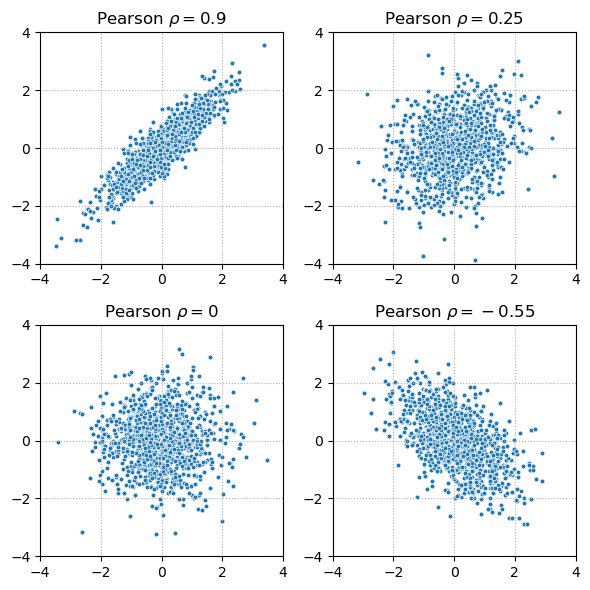

In [36]:
from scipy.stats import norm
from scipy.stats import pearsonr
import matplotlib.pyplot as plt, numpy as np
%matplotlib inline

fig,ax = plt.subplots(2,2,figsize=(6,6))
for axi,rho in zip(ax.flatten(),(.9,.25, 0, -.55)):
    a = rho
    b = np.sqrt(1 - a**2)
    xdata = norm.rvs(size=1000)
    ydata = (a*xdata + b*norm.rvs(size=1000))
    axi.scatter(xdata,ydata, s=12, ec='w', lw=.5)
    axi.axis([-4,4,-4,4])
    axi.grid(ls=':')
    axi.set(yticks=range(-4,5,2), title=f'Pearson $\\rho={rho}$')
plt.tight_layout()

**B. The code should work as well for any value of $\rho$ satisying $-1\le \rho \le 1$. Make a similar set of four plots for the values of Pearson $\rho$ = (-.1, .5, .333, -.75).**

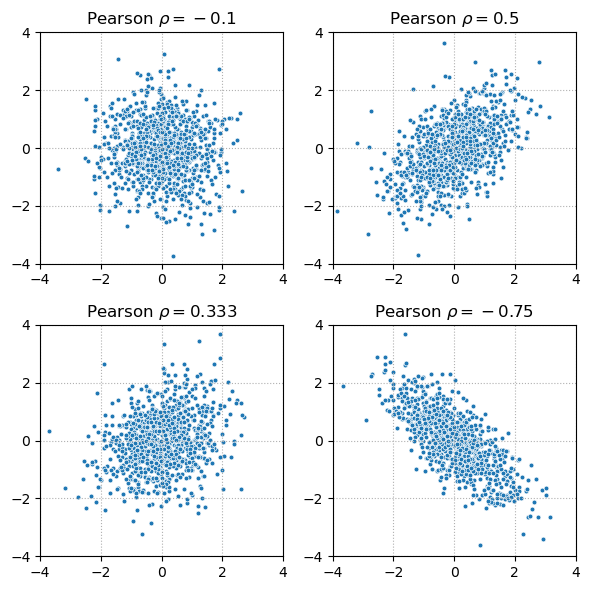

In [38]:
fig,ax = plt.subplots(2,2,figsize=(6,6))
for axi,rho in zip(ax.flatten(),(-.1, .5, .333, -.75)):
    a = rho
    b = np.sqrt(1 - a**2)
    xdata = norm.rvs(size=1000)
    ydata = (a*xdata + b*norm.rvs(size=1000))
    axi.scatter(xdata,ydata, s=12, ec='w', lw=.5)
    axi.axis([-4,4,-4,4])
    axi.grid(ls=':')
    axi.set(yticks=range(-4,5,2), title=f'Pearson $\\rho={rho}$')
plt.tight_layout()